In [ ]:
# imports
import cv2  # for image handeling stuff
import numpy as np  # for matrix operations & cv2
from matplotlib import pyplot as plt  # for plotting
from matplotlib.pyplot import imshow  # cause i'm lazy to write plt.

# from tqdm import tqdm
import math  # math related tasks
from bresenham import bresenham as line_iter  # generates point along a line


In [ ]:
def create_circular_mask(h, w, center=None, radius=None):
    """
    Creates a circular mask for an image of given height and width.

    Parameters:
    h (int): Height of the image.
    w (int): Width of the image.
    center (tuple, optional): The (x, y) coordinates of the circle's center. Defaults to the center of the image.
    radius (int, optional): The radius of the circle. Defaults to the smallest distance from the center to the image edges.

    Returns:
    numpy.ndarray: A boolean mask with the same dimensions as the input image, where True values represent the inside of the circle.
    """

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center <= radius
    return mask


In [ ]:
# magic numbbers
width_of_line = 6
weight_of_line = 32
path_to_input_img = "rick_vigq.png"
img_size = (500, 500)
number_of_nails = 400


110.575532


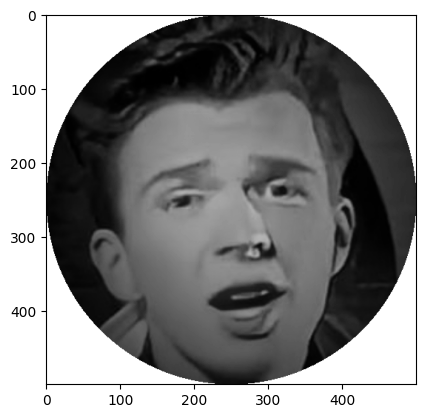

In [ ]:
# load, resize & grayscaling the image
img = cv2.imread(path_to_input_img)
img = cv2.resize(img, img_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# in orig i save the original image for later use
orig = img.copy()
mask = create_circular_mask(orig.shape[0], orig.shape[1])
orig[~mask] = 255

# stopping point is some kind of threshold where to stop
# when the canvas image has "leve" of overall brightness
stopping_point = np.mean(orig)
print(stopping_point)

# canvas - a image where i draw the lines
canvas = np.full_like(img, 255)
canvas[0, 0] = 0
canvas[0, 1] = 255

imshow(orig, cmap="gray")


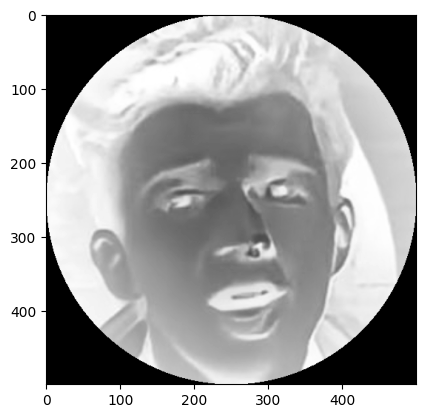

In [ ]:
# the image
imgcircle = img.copy()
# i mask the image out
imgcircle[~mask] = 255
# and invert it
# that's because I draw with black lines onto a white plane
# so the most black region becomes the most white, with max value
imginverted = np.full(img.shape, 255) - imgcircle

img = imginverted

imshow(img, cmap="gray")


In [ ]:
def generate_circle_points(center, radius, n):
    """
    Generate points on the circumference of a circle.

    Parameters:
    center (tuple): A tuple (x, y) representing the coordinates of the circle's center.
    radius (float): The radius of the circle.
    n (int): The number of points to generate on the circle's circumference.

    Returns:
    list: A list of tuples, where each tuple represents the (x, y) coordinates of a point on the circle's circumference.
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    points = [
        (center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle))
        for angle in angles
    ]
    return points


center = (img.shape[0] // 2, img.shape[1] // 2)
radius = min(img.shape) // 2 - 5
# number of point
n = number_of_nails
# these are basically the nails around
circle_points = generate_circle_points(center, radius, n)

img_gray = np.full_like(img, 0, dtype=np.uint8)
for point in circle_points:
    img_gray[int(point[1]), int(point[0])] = 255
    cv2.line(
        img_gray, (int(point[1]), int(point[0])), (int(point[1]), int(point[0])), 255, 1
    )

# imshow(img_gray, cmap="gray")

# array for the nails to be wrapped around
spagat = [0]


In [ ]:
while True:
    # i get the last nail, where the string ends
    from_pos = circle_points[spagat[-1]]
    # this is a structure for the best nail that i could find
    # first value is which nail is currentlly best, second is the best found value
    best = [-1, -math.inf]

    # i iterate over all of the other nails
    for indx, to_pos in enumerate(circle_points):
        if indx == spagat[-1]:
            continue

        # i iterate over the line that i may draw, and i save all the points on the line
        lajna = []
        for x, y in line_iter(
            int(from_pos[0]), int(from_pos[1]), int(to_pos[0]), int(to_pos[1])
        ):
            lajna.append(img[y, x])

        lajna = np.array(lajna)
        # how much of a "correct" gray would I add
        prekryv = np.sum(lajna)

        # and if I would add more, i update the best
        if prekryv > best[1]:
            best = [indx, prekryv]
            bst = (from_pos, to_pos)
            best_lajna = lajna

    # I draw the best line onto a image
    canvas_w_line = cv2.line(
        np.full_like(canvas, 0),
        tuple(map(int, from_pos)),
        tuple(map(int, circle_points[best[0]])),
        weight_of_line,
        width_of_line,
    )

    # which i then draw to the canvas (where I keep all the lines)
    canvas = cv2.subtract(canvas, canvas_w_line)
    # and also from the image that I use to keep track of where i need to add lines
    img = cv2.subtract(img, canvas_w_line, dtype=cv2.CV_8U)

    # i append the nail to the spagat
    spagat.append(best[0])

    print(np.mean(canvas))
    # and when i reach the stopping point, I stop
    if np.mean(canvas) < stopping_point:
        break


254.560324
254.122052
253.683012
253.232452
252.782276
252.358084
251.984196
251.66458
251.325124
250.971588
250.630596
250.271172
249.93018
249.587652
249.154372
248.718276
248.28602
247.945156
247.583812
247.2537
246.934212
246.504004
246.067396
245.62554
245.185732
244.84026
244.516292
244.160196
243.8425
243.404612
242.963652
242.533572
242.084036
241.64794
241.269572
240.904772
240.571588
240.234564
239.784132
239.36826
238.983876
238.67002
238.36602
238.033988
237.717572
237.385284
237.025604
236.657348
236.333508
236.002884
235.655876
235.312836
234.895044
234.453572
234.014916
233.578436
233.141828
232.720452
232.36794
231.991492
231.553476
231.115332
230.73146
230.311364
229.874756
229.4329
228.996804
228.58746
228.219588
227.908292
227.61722
227.310788
227.018308
226.6617
226.320068
225.885764
225.445828
225.00922
224.569924
224.124132
223.716452
223.35434
222.99914
222.569572
222.135396
221.703908
221.269348
220.845552
220.427888
219.98104
219.55038
219.124224
218.720656
218

110.467028


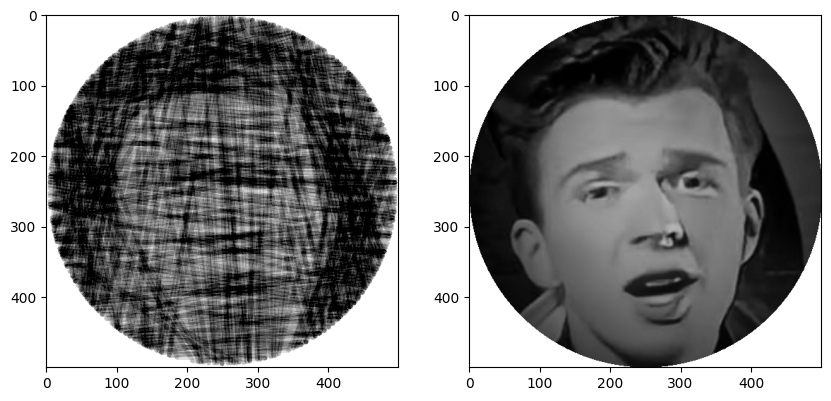

In [ ]:
print(np.mean(canvas))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(
    canvas,
    cmap="gray",
)
plt.subplot(1, 2, 2)
imshow(orig, cmap="gray")
